In [1]:
import os, sys

sys.path.append('..' + os.sep + 'preprocess2')

from common import*

from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

FilterNeurokitWarnings()

In [2]:
BEG_TRAIN = '..' + os.sep + 'preprocess2' + os.sep + 'AgeGroups' + os.sep + '0' + os.sep
BEG_TEST = '..' + os.sep + 'data' + os.sep + 'TestData' + os.sep

dfAgeSex = pd.read_csv(BEG_TEST + 'attributes.csv')
with h5py.File(BEG_TEST + 'ecg_tracings.hdf5') as f:
    M = np.array(f['tracings'])
dfLabels = pd.read_csv(BEG_TEST + 'annotations' + os.sep + 'gold_standard.csv')

def GetTestAge(i):
    return dfAgeSex.values[i][0]

testLabels = dfLabels.values
# deixar as labels na mesma ordem do treino
testLabels[:,4], testLabels[:,5] = testLabels[:,5], testLabels[:,4].copy()

def GetTargetAgeGroupStr(start, end):
    return str(start) + '-' + str(end)

def GetModelIllOnly(targetAgeGroup):
    start = BEG_TRAIN + targetAgeGroup + os.sep
    mappings = np.load(start + 'mappings.npy')
    ecgs = np.load(start + 'ecgs.npy')
    ondas = np.load(start + 'ondas.npy')
    labels = np.load(start + 'labels.npy')
    
    newOndas = []
    newEcgs = []
    newLabels = []
    newMappings = []
    
    curNewIdx = 0
    ondaIdx = 0
    O = len(ondas)
    for ecgAndLabelIdx in range(len(labels)):    
        l = labels[ecgAndLabelIdx]
        if np.any(l):
            orgEcg = ecgs[ecgAndLabelIdx]
            newEcgs.append(orgEcg)
            newLabels.append(l)
            while ondaIdx < O and mappings[ondaIdx] == ecgAndLabelIdx:
                onda = ondas[ondaIdx]
                newOndas.append(onda)
                newMappings.append(curNewIdx)
                ondaIdx += 1
            curNewIdx += 1
        while ondaIdx < O and mappings[ondaIdx] <= ecgAndLabelIdx:
            ondaIdx += 1

    newOndas = np.array(newOndas)
    newEcgs = np.array(newEcgs)
    newLabels = np.array(newLabels)
    newMappings = np.array(newMappings)
    
    tree = KDTree(newOndas, metric='minkowski')
    return tree, newEcgs, newLabels, newMappings

def GetWavesCoeffs(ecg):
    w = ecg - ecg.mean()
    try:
        d = nk.ecg_delineate(w, sampling_rate=SAMPLE_RATE)[1]
    except:
        raise Exception('Neurokit não conseguiu delinear esse ECG')
    
    starts = d['ECG_P_Onsets']
    coeffs = []
    for j in range(len(starts) - 1):
        cur = starts[j]
        nxt = starts[j + 1]
        if math.isnan(cur) or math.isnan(nxt):
            #print('Neurokit retornou nan')
            continue
            
        period = w[cur:nxt]
        if not len(period):
            print('Neurokit retornou período vazio')
            break
            
        coeffs.append(GetCoeff(period))
    
    if not len(coeffs):
        raise Exception('Neurokit não conseguiu encontrar batimentos nesse ECG')
        
    return coeffs
    
def GetLabelsInNewAgeGroup(coeffs, model):
    '''
    retorna o ECG mais próximo no espaço de features na nova idade dado os coeficientes no espaço de features
    de cada batimento e o modelo
    '''

    tree, ecgs, labels, mappings = model
        
    dist, ind = tree.query(coeffs)
    gIdx = dist.argmin()
    idxClosestOnda = ind[gIdx][0]
    ecgOrgRow = mappings[idxClosestOnda]
    labelsEcgClosest = labels[ecgOrgRow]
    return labelsEcgClosest

In [3]:
def get_group_results(age_pair, age_groups):
    
    accuracy = []
    sample = dfAgeSex[(dfAgeSex['age'] >= age_pair[0]) & (dfAgeSex['age'] <= age_pair[1])].copy()
    
    coeffs = []
    pessoaLabels = []
    for pessoa in sample.index:
        labels = testLabels[pessoa]
        if not np.any(labels):
            continue
            
        ecg = M[pessoa, :, ELETRODO_IDX]
        def tryGet():
            try:
                return GetWavesCoeffs(ecg)
            except Exception as e:
                print(e, pessoa)
                return None
        c = tryGet()
        if c is not None:
            coeffs.append(c)
            pessoaLabels.append(labels)
    
    for age_group in age_groups:
        
        targetAgeGroup = GetTargetAgeGroupStr(*age_group)
        model = GetModelIllOnly(targetAgeGroup)
        matched = []
        
        for c, labels in zip(coeffs, pessoaLabels):
            labelsEcgClosest = GetLabelsInNewAgeGroup(c, model)
            cmp = labels == labelsEcgClosest
            matched.append(cmp)

        if not len(matched):
            acc = 1
        else:
            matched = np.array(matched)
            acc = (matched.sum(axis=1)==6).mean()
        accuracy.append(acc)
        
    return np.array(accuracy)

In [4]:
def plot_accuracy(age_groups, target_age, results):
    plt.figure(figsize=(12,8))
    plt.plot(np.array(age_groups)[:,0], results)
    plt.xlabel('Age group')
    plt.ylabel('Accuracy score')
    plt.title('Accuracy score X Age group - (' + str(target_age[0]) + ',' + str(target_age[1]) + ')')
    plt.xticks(ticks=np.array(age_groups)[:,0],labels=[str(i) for i in age_groups])
    plt.show()

In [5]:
age_groups = [(a, a + 4) for a in range(17, 88, 5)]

In [6]:
accuracy = get_group_results((17,21), age_groups)

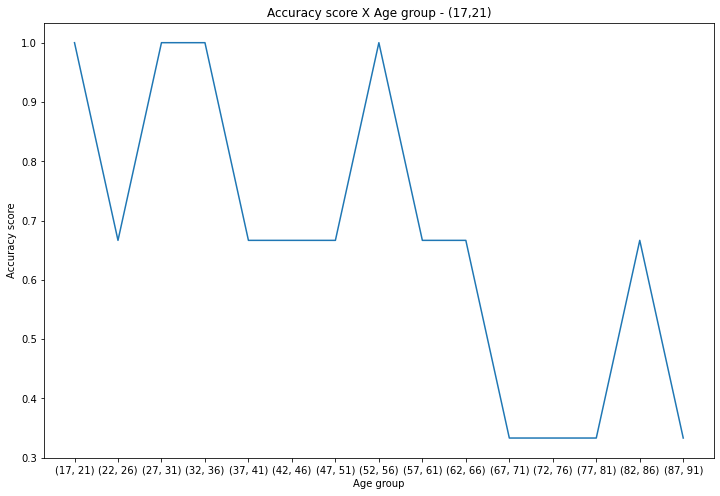

In [7]:
plot_accuracy(age_groups, (17,21), accuracy)

In [8]:
accuracy2 = get_group_results((22,26), age_groups)

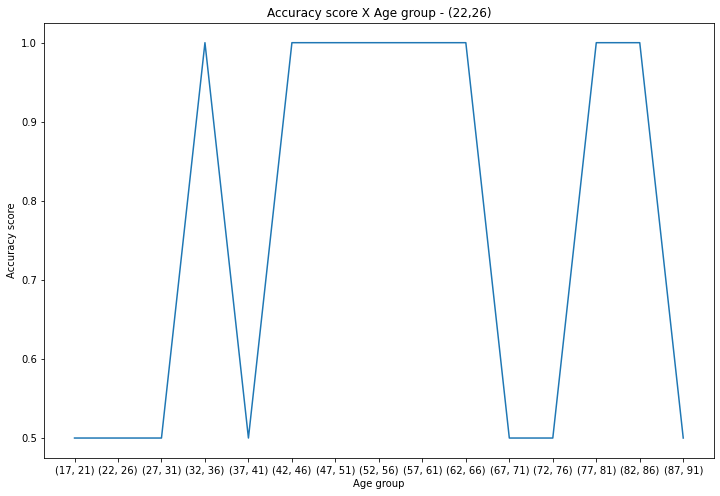

In [9]:
plot_accuracy(age_groups, (22,26), accuracy2)

In [10]:
accuracy3 = get_group_results((27,31), age_groups)

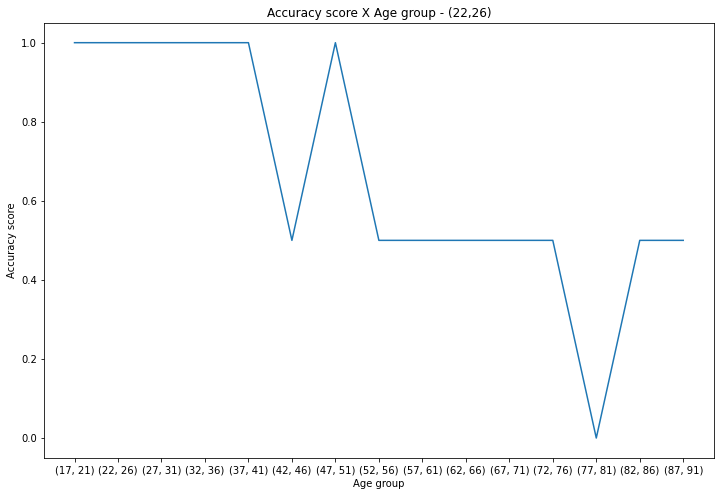

In [11]:
plot_accuracy(age_groups, (22,26), accuracy3)

In [12]:
accuracy4 = get_group_results((32,36), age_groups)

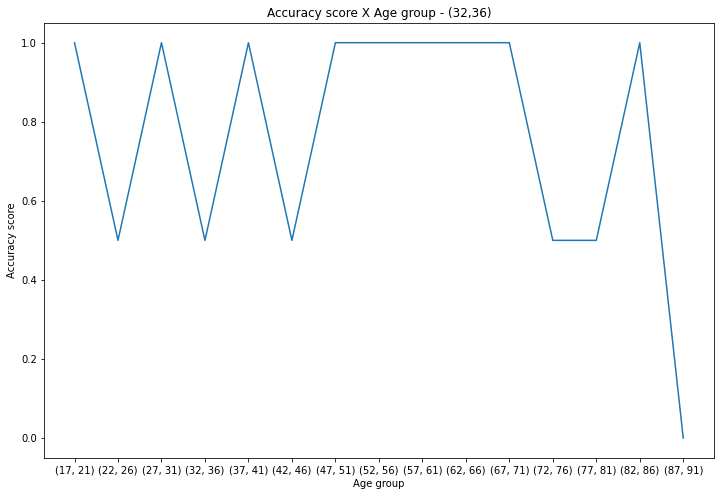

In [13]:
plot_accuracy(age_groups, (32,36), accuracy4)

In [14]:
accuracy5 = get_group_results((37,41), age_groups)

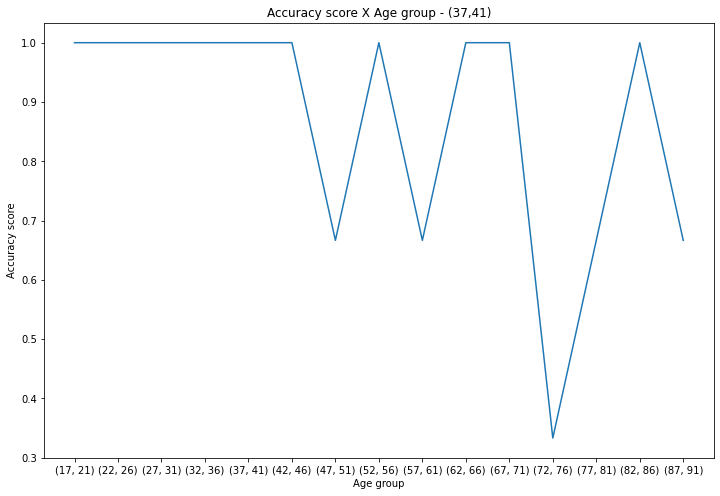

In [15]:
plot_accuracy(age_groups, (37,41), accuracy5)

In [16]:
accuracy6 = get_group_results((42,46), age_groups)

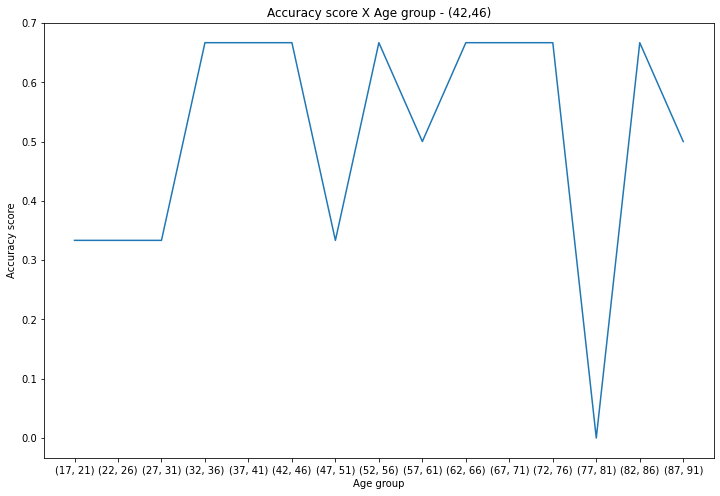

In [17]:
plot_accuracy(age_groups, (42,46), accuracy6)

In [18]:
accuracy7 = get_group_results((47,51), age_groups)

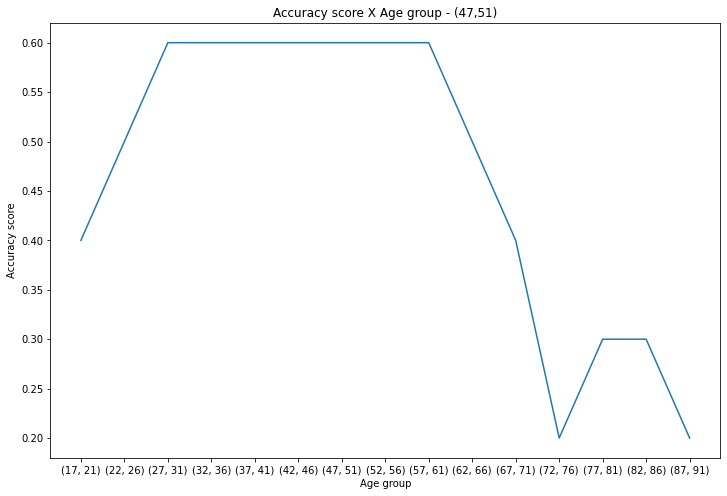

In [19]:
plot_accuracy(age_groups, (47,51), accuracy7)

In [20]:
accuracy8 = get_group_results((52,56), age_groups)

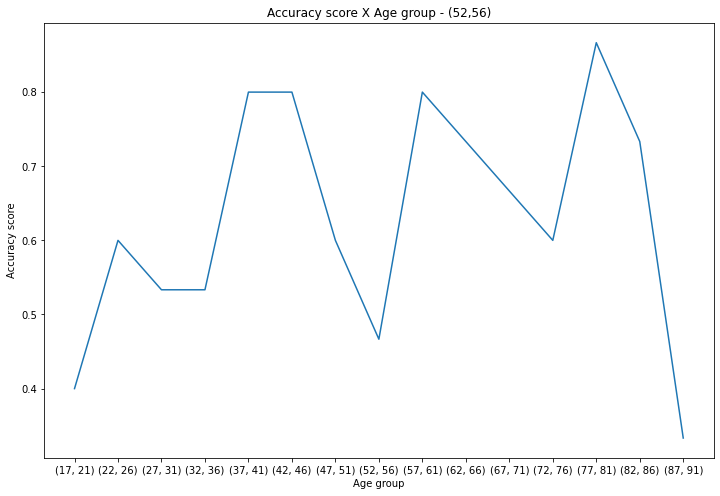

In [21]:
plot_accuracy(age_groups, (52,56), accuracy8)

In [22]:
accuracy9 = get_group_results((57,61), age_groups)

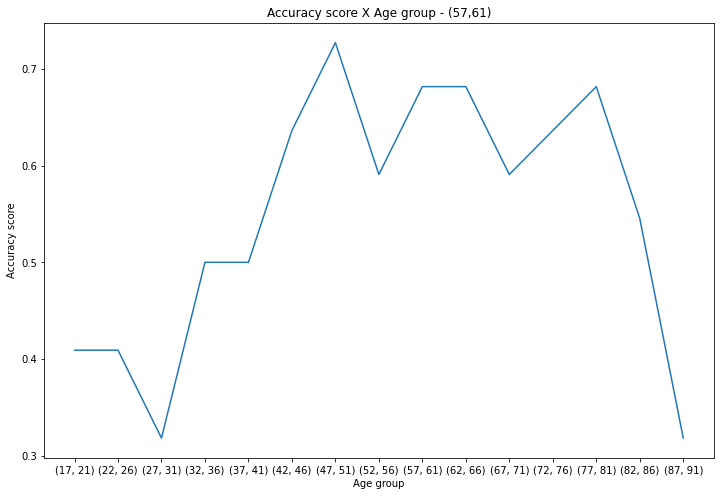

In [23]:
plot_accuracy(age_groups, (57,61), accuracy9)

In [24]:
accuracy10 = get_group_results((62,66), age_groups)

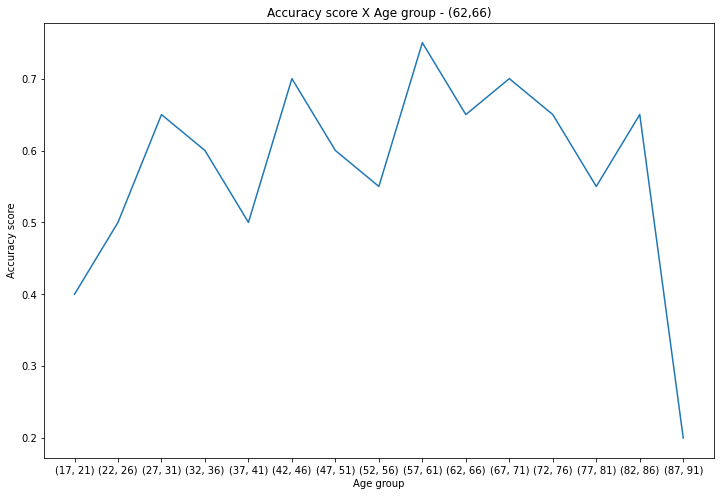

In [25]:
plot_accuracy(age_groups, (62,66), accuracy10)

In [26]:
accuracy10_1 = get_group_results((67,71), age_groups)

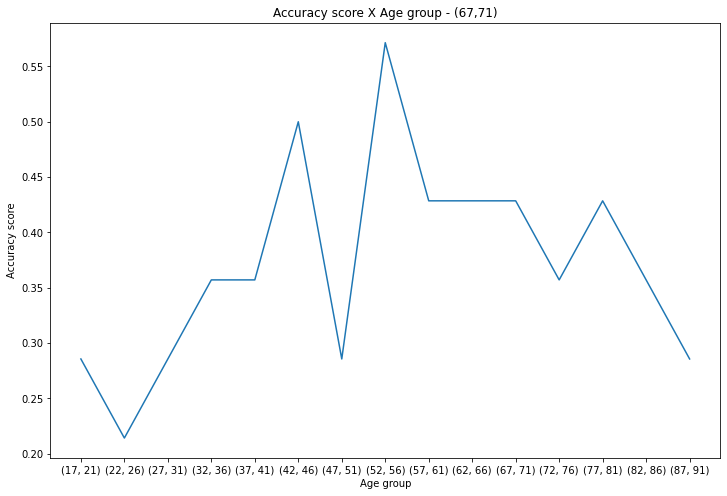

In [27]:
plot_accuracy(age_groups, (67,71), accuracy10_1)

In [28]:
accuracy10_2 = get_group_results((72,76), age_groups)

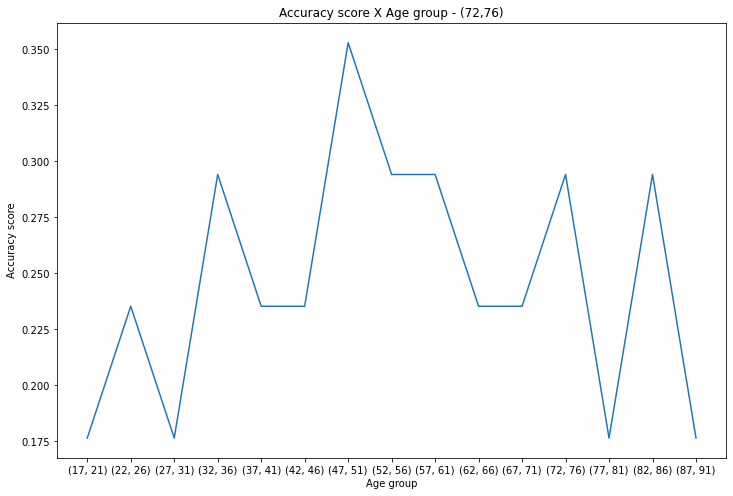

In [29]:
plot_accuracy(age_groups, (72,76), accuracy10_2)

In [30]:
accuracy11 = get_group_results((77,81), age_groups)

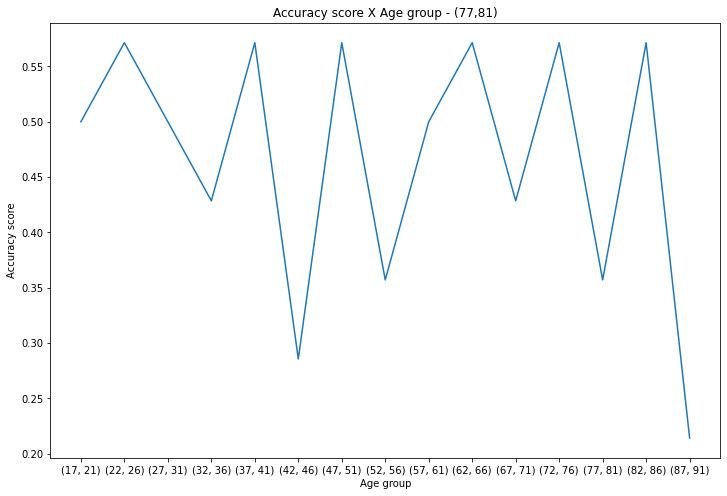

In [31]:
plot_accuracy(age_groups, (77,81), accuracy11)

In [32]:
accuracy12 = get_group_results((82,86), age_groups)

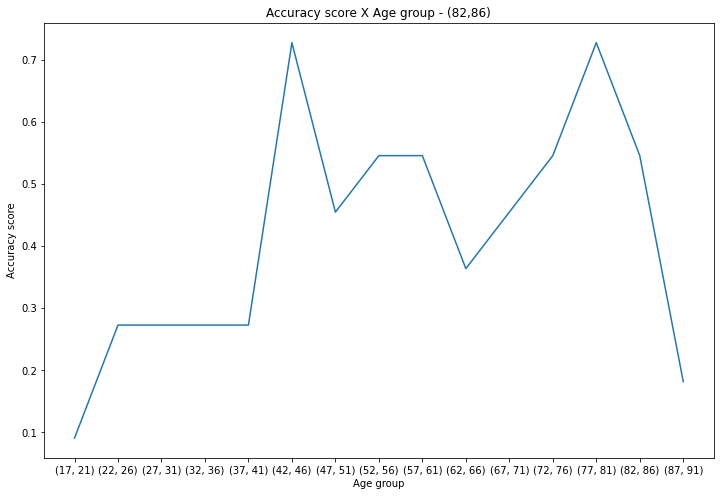

In [33]:
plot_accuracy(age_groups, (82,86), accuracy12)

In [34]:
accuracy13 = get_group_results((87,91), age_groups)

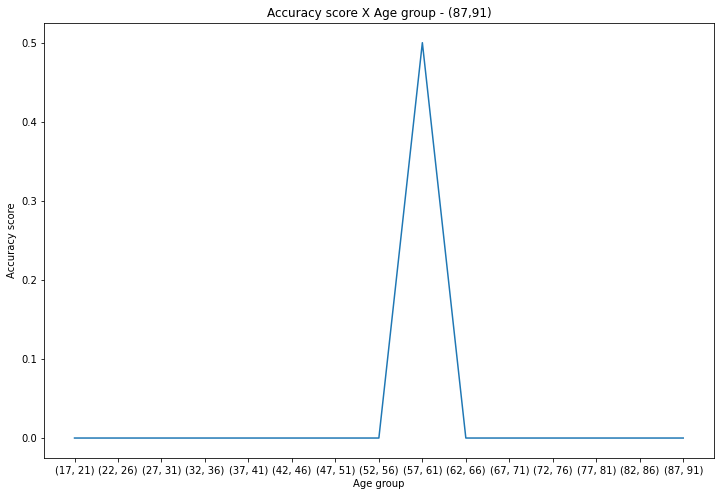

In [35]:
plot_accuracy(age_groups, (87,91), accuracy13)

In [36]:
import seaborn as sns

In [37]:
df = pd.DataFrame(np.array([accuracy
                           ,accuracy2, accuracy3
                           ,accuracy4, accuracy5
                           ,accuracy6, accuracy7
                           ,accuracy8, accuracy9
                           ,accuracy10, accuracy10_1
                           ,accuracy10_2, accuracy11
                           ,accuracy12,accuracy13]), columns=age_groups, index=age_groups)

In [38]:
df

,"(17, 21)","(22, 26)","(27, 31)","(32, 36)","(37, 41)","(42, 46)","(47, 51)","(52, 56)","(57, 61)","(62, 66)","(67, 71)","(72, 76)","(77, 81)","(82, 86)","(87, 91)"
"(17, 21)",1.000000,0.666667,1.000000,1.000000,0.666667,0.666667,0.666667,1.000000,0.666667,0.666667,0.333333,0.333333,0.333333,0.666667,0.333333
"(22, 26)",0.500000,0.500000,0.500000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,1.000000,1.000000,0.500000
"(27, 31)",1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000
"(32, 36)",1.000000,0.500000,1.000000,0.500000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,1.000000,0.000000
"(37, 41)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,0.666667,1.000000,1.000000,0.333333,0.666667,1.000000,0.666667
"(42, 46)",0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,0.333333,0.666667,0.500000,0.666667,0.666667,0.666667,0.000000,0.666667,0.500000
"(47, 51)",0.400000,0.500000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.500000,0.400000,0.200000,0.300000,0.300000,0.200000
"(52, 56)",0.400000,0.600000,0.533333,0.533333,0.800000,0.800000,0.600000,0.466667,0.800000,0.733333,0.666667,0.600000,0.866667,0.733333,0.333333
"(57, 61)",0.409091,0.409091,0.318182,0.500000,0.500000,0.636364,0.727273,0.590909,0.681818,0.681818,0.590909,0.636364,0.681818,0.545455,0.318182
"(62, 66)",0.400000,0.500000,0.650000,0.600000,0.500000,0.700000,0.600000,0.550000,0.750000,0.650000,0.700000,0.650000,0.550000,0.650000,0.200000


<AxesSubplot:>

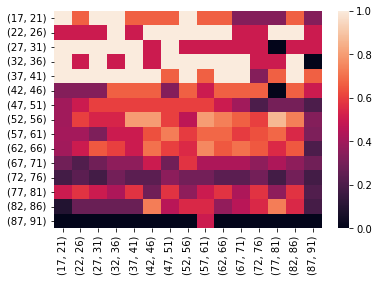

In [39]:
sns.heatmap(df)